<a href="https://colab.research.google.com/github/shankythinks/Signature-forgery-Detection-Model/blob/main/Signature_forgery_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Processing 0 files: 100%|██████████| 1320/1320 [03:11<00:00,  6.91it/s]


Loading combined dataset from HDF5...
Dataset loaded. Features shape: (2639, 4318), Labels shape: (2639,)
Standardizing features...
Splitting dataset...
Training KNN model...
Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   5.3s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   5.4s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   5.2s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   5.4s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   5.2s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   5.0s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   5.7s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   5.0s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   5.2s
[CV] END ...............n_neighbor

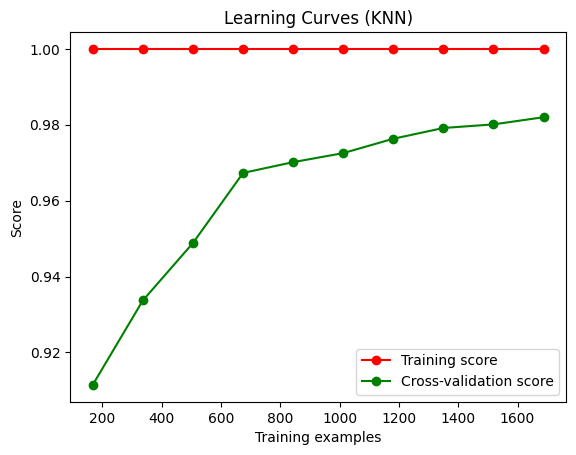

In [ ]:
import os
import cv2
import numpy as np
import h5py
from scipy.stats import skew, kurtosis
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Paths to datasets
real_signatures_path = "/content/drive/MyDrive/CSI_2/data/real"
forged_signatures_path = "/content/drive/MyDrive/CSI_2/data/forged"
hdf5_file = "signature_features_knn_tuned.h5"

# Preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = cv2.GaussianBlur(img, (5, 5), 0)
    _, binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        img = img[y:y+h, x:x+w]
    return img

# Extract features from the image (with LBP parameter variations)
def extract_features(img, lbp_radius=1, lbp_points=8):
    features = []
    # Basic features
    h, w = img.shape
    features.append(h / w)
    binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    moments = cv2.moments(binary_img)
    if moments["m00"] != 0:
        centroid_x = moments["m10"] / moments["m00"]
        centroid_y = moments["m01"] / moments["m00"]
    else:
        centroid_x, centroid_y = 0, 0
    features.extend([centroid_x / w, centroid_y / h])
    dist_transform = cv2.distanceTransform(binary_img, cv2.DIST_L2, 3)
    stroke_width = np.mean(dist_transform)
    features.append(stroke_width)
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        stroke_length = cv2.arcLength(max(contours, key=cv2.contourArea), True)
    else:
        stroke_length = 0
    features.append(stroke_length)
    flattened = img.flatten()
    features.append(skew(flattened))
    features.append(kurtosis(flattened))
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    features.extend(hist.flatten() / np.sum(hist))
    lbp = local_binary_pattern(img, P=lbp_points, R=lbp_radius, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp_points + 2), range=(0, lbp_points + 1))
    lbp_hist = lbp_hist / np.sum(lbp_hist)
    features.extend(lbp_hist)
    img_resized = cv2.resize(img, (128, 64))
    hog_features = hog(img_resized, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm="L2-Hys")
    features.extend(hog_features)

    # Stroke Density and Distribution
    grid_size = 16
    cell_height, cell_width = img.shape[0] // grid_size, img.shape[1] // grid_size
    for i in range(grid_size):
        for j in range(grid_size):
            cell = binary_img[i * cell_height:(i + 1) * cell_height, j * cell_width:(j + 1) * cell_width]
            density = np.sum(cell == 0) / cell.size
            features.append(density)

    # Contour Features (Contour Complexity)
    if contours:
        contour = max(contours, key=cv2.contourArea)
        perimeter = cv2.arcLength(contour, True)
        area = cv2.contourArea(contour)
        if area > 0:
            complexity = perimeter / area
            features.append(complexity)
        else:
            features.append(0) #handle divide by zero
    else:
        features.append(0)

    # White Space Analysis (White Space Area)
    contours_white, _ = cv2.findContours(255 - binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    white_area = 0
    for contour in contours_white:
        white_area += cv2.contourArea(contour)
    features.append(white_area / (img.shape[0] * img.shape[1])) #normalized

    return features

# Save features to HDF5 (with LBP parameter variations)
def save_to_hdf5(dataset_path, label, hdf5_file, lbp_radius=1, lbp_points=8):
    with h5py.File(hdf5_file, "a") as h5f:
        files = [file for file in os.listdir(dataset_path) if file.endswith((".png", ".jpg"))]
        for file in tqdm(files, desc=f"Processing {label} files"):
            file_path = os.path.join(dataset_path, file)
            try:
                img = preprocess_image(file_path)
                features = extract_features(img, lbp_radius, lbp_points)
                dataset_name = f"{label}_{os.path.splitext(file)[0]}"
                h5f.create_dataset(dataset_name, data=features + [label])
            except Exception as e:
                print(f"Error processing {file}: {e}")

# Load features from HDF5
def load_hdf5_data(hdf5_file):
    with h5py.File(hdf5_file, "r") as h5f:
        data = []
        labels = []
        for key in h5f.keys():
            dataset = h5f[key][:]
            data.append(dataset[:-1])
            labels.append(dataset[-1])
        return np.array(data), np.array(labels)

# Save features to HDF5 (using varied LBP parameters)
save_to_hdf5(real_signatures_path, 1, hdf5_file, lbp_radius=2, lbp_points=16)
save_to_hdf5(forged_signatures_path, 0, hdf5_file, lbp_radius=2, lbp_points=16)

# Load combined data
print("Loading combined dataset from HDF5...")
X, y = load_hdf5_data(hdf5_file)
print(f"Dataset loaded. Features shape: {X.shape}, Labels shape: {y.shape}")

# Standardize features
print("Standardizing features...")
scaler = StandardScaler() # or MinMaxScaler()
X = scaler.fit_transform(X)

# Train-test split
print("Splitting dataset...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# KNN Model
print("Training KNN model...")
knn = KNeighborsClassifier()
param_grid_knn = {
    "n_neighbors": list(range(1, 21)),
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring="accuracy", verbose=2)
grid_search_knn.fit(X_train, y_train)
best_knn = grid_search_knn.best_estimator_
print("KNN Best Parameters:", grid_search_knn.best_params_)
print("KNN Best CV Accuracy:", grid_search_knn.best_score_)
y_pred_knn = best_knn.predict(X_test)
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("KNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

# Learning Curves
train_sizes, train_scores, test_scores = learning_curve(best_knn, X_train, y_train, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10))
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.figure()
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curves (KNN)")
plt.legend(loc="best")
plt.show()

# Validation Curves
param_range = list(range(1, 21))
train_scores, test_scores = validation_curve(best_knn, X_train, y_train, param_name="n_neighbors", param_range=param_range, cv=5, scoring="accuracy")
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.figure()
plt.plot(param_range, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(param_range, test_scores_mean, "o-", color="g", label="Cross-validation score")
plt.xlabel("n_neighbors")
plt.ylabel("Score")
plt.title("Validation Curves (KNN)")
plt.legend(loc="best")
plt.show()

# Save Models and Scaler
joblib.dump(best_knn, "signature_forgery_detector_knn_improved.pkl")
joblib.dump(scaler, "scaler_improved.pkl")
print("Models and scaler saved.")

def predict_signature(image_path):
    model = joblib.load("signature_forgery_detector_knn_improved.pkl")
    scaler = joblib.load("scaler_improved.pkl")
    img = preprocess_image(image_path)
    features = extract_features(img, lbp_radius=2, lbp_points=16)
    features = np.array(features).reshape(1, -1)
    features = scaler.transform(features)
    prediction = model.predict(features)
    return "Genuine" if prediction[0] == 1 else "Forged"